# An Introduction to Federated Learning

Welcome to the Flower federated learning tutorial!

In this notebook, we'll build a federated learning system using Flower and PyTorch. In part 1, we use PyTorch for the model training pipeline and data loading. In part 2, we continue to federate the PyTorch-based pipeline using Flower.

> [Star Flower on GitHub](https://github.com/adap/flower) ⭐️ and join the Flower community on Slack to connect, ask questions, and get help: [Join Slack](https://flower.dev/join-slack) 🌼 We'd love to hear from you in the `#introductions` channel! And if anything is unclear, head over to the `#questions` channel.

Let's get stated!

## Step 0: Preparation

Before we begin with any actual code, let's make sure that we have everything we need.

### Installing dependencies

Next, we install the necessary packages for PyTorch (`torch` and `torchvision`) and Flower (`flwr`):

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [2]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics
import flwr.common

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.0.0 and Flower 1.4.0


It is possible to switch to a runtime that has GPU acceleration enabled (on Google Colab: `Runtime > Change runtime type > Hardware acclerator: GPU > Save`). Note, however, that Google Colab is not always able to offer GPU acceleration. If you see an error related to GPU availability in one of the following sections, consider switching back to CPU-based execution by setting `DEVICE = torch.device("cpu")`. If the runtime has GPU acceleration enabled, you should see the output `Training on cuda`, otherwise it'll say `Training on cpu`.


### Loading the data

Federated learning can be applied to many different types of tasks across different domains. In this tutorial, we introduce federated learning by training a simple convolutional neural network (CNN) on the popular CIFAR-10 dataset. CIFAR-10 can be used to train image classifiers that distinguish between images from ten different classes:

In [3]:
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

We simulate having multiple datasets from multiple organizations (also called the "cross-silo" setting in federated learning) by splitting the original CIFAR-10 dataset into multiple partitions. Each partition will represent the data from a single organization. We're doing this purely for experimentation purposes, in the real world there's no need for data splitting because each organization already has their own data (so the data is naturally partitioned).

Each organization will act as a client in the federated learning system. So having ten organizations participate in a federation means having ten clients connected to the federated learning server:


In [4]:
NUM_CLIENTS = 10


Let's now load the CIFAR-10 training and test set, partition them into ten smaller datasets (each split into training and validation set), and wrap the resulting partitions by creating a PyTorch `DataLoader` for each of them:

In [5]:
from torch.utils.data import Dataset
class custom_subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
        labels(sequence) : targets as required for the indices. will be the same length as indices
    """
    def __init__(self, dataset, indices, labels):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.targets = labels
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        target = self.targets[idx]
        return (image, target)

    def __len__(self):
        return len(self.targets)

In [6]:
BATCH_SIZE = 32

from collections import Counter

def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for idx, ds in enumerate(datasets):
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        # Always splits in the same way.

        # print(dict(Counter(ds_train.targets)))
        # custom_subset(ds_train)
        arr = []
        print("ds_train", idx)
        for a in ds_train:
            arr.append(a[1])
        for i in range(10):
            print(i, ":", arr.count(i))
        # Data is not perfectly distributed


        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified
ds_train 0
0 : 474
1 : 443
2 : 427
3 : 411
4 : 444
5 : 447
6 : 475
7 : 467
8 : 463
9 : 449
ds_train 1
0 : 438
1 : 480
2 : 450
3 : 451
4 : 462
5 : 431
6 : 453
7 : 455
8 : 420
9 : 460
ds_train 2
0 : 474
1 : 453
2 : 444
3 : 460
4 : 464
5 : 392
6 : 470
7 : 438
8 : 458
9 : 447
ds_train 3
0 : 474
1 : 423
2 : 433
3 : 449
4 : 482
5 : 463
6 : 439
7 : 456
8 : 447
9 : 434
ds_train 4
0 : 444
1 : 467
2 : 455
3 : 447
4 : 448
5 : 448
6 : 421
7 : 444
8 : 446
9 : 480
ds_train 5
0 : 446
1 : 439
2 : 469
3 : 469
4 : 441
5 : 480
6 : 425
7 : 418
8 : 454
9 : 459
ds_train 6
0 : 441
1 : 456
2 : 451
3 : 453
4 : 473
5 : 458
6 : 458
7 : 451
8 : 445
9 : 414
ds_train 7
0 : 418
1 : 458
2 : 477
3 : 457
4 : 438
5 : 436
6 : 437
7 : 437
8 : 464
9 : 478
ds_train 8
0 : 444
1 : 448
2 : 427
3 : 441
4 : 445
5 : 462
6 : 454
7 : 483
8 : 455
9 : 441
ds_train 9
0 : 432
1 : 463
2 : 481
3 : 422
4 : 422
5 : 462
6 : 464
7 : 447
8 : 463
9 : 444


We now have a list of ten training sets and ten validation sets (`trainloaders` and `valloaders`) representing the data of ten different organizations. Each `trainloader`/`valloader` pair contains 4500 training examples and 500 validation examples. There's also a single `testloader` (we did not split the test set). Again, this is only necessary for building research or educational systems, actual federated learning systems have their data naturally distributed across multiple partitions.

Let's take a look at the first batch of images and labels in the first training set (i.e., `trainloaders[0]`) before we move on:

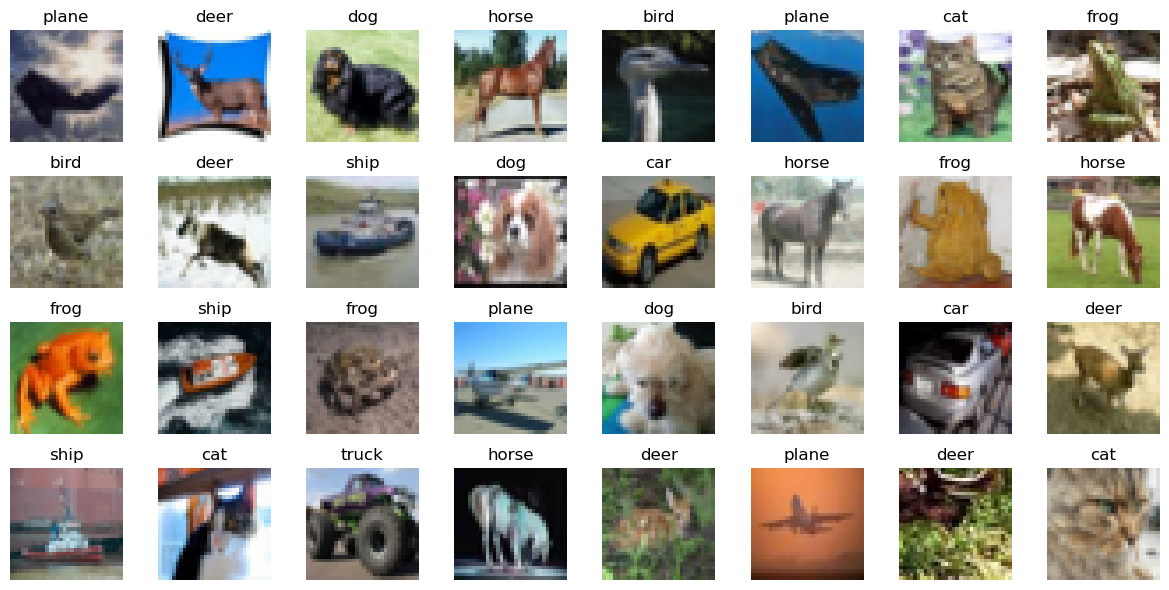

In [7]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

The output above shows a random batch of images from the first `trainloader` in our list of ten `trainloaders`. It also prints the labels associated with each image (i.e., one of the ten possible labels we've seen above). If you run the cell again, you should see another batch of images.

## Step 1: Centralized Training with PyTorch



Next, we're going to use PyTorch to define a simple convolutional neural network. This introduction assumes basic familiarity with PyTorch, so it doesn't cover the PyTorch-related aspects in full detail. If you want to dive deeper into PyTorch, we recommend [*DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ*](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).


### Defining the model

We use the simple CNN described in the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network):

In [8]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Let's continue with the usual training and test functions:

In [9]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### Training the model

We now have all the basic building blocks we need: a dataset, a model, a training function, and a test function. Let's put them together to train the model on the dataset of one of our organizations (`trainloaders[0]`). This simulates the reality of most machine learning projects today: each organization has their own data and trains models only on this internal data: 

In [10]:
EPOCH = 50

In [11]:
import os
# 여기서는 10개로 나눈 것 중, 하나만 train 함.

trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)
trained_path = "./dataset/trained_centralized.pkl"


if not (os.path.isfile(trained_path)):
    for epoch in range(EPOCH):
        train(net, trainloader, 1)
        loss, accuracy = test(net, valloader)
        print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
    torch.save(net.state_dict(), trained_path)
else :
    net.load_state_dict(torch.load(trained_path))
loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Final test set performance:
	loss 0.1795283366918564
	accuracy 0.4507


Training the simple CNN on our CIFAR-10 split for 5 epochs should result in a test set accuracy of about 41%, which is not good, but at the same time, it doesn't really matter for the purposes of this tutorial. The intent was just to show a simplistic centralized training pipeline that sets the stage for what comes next - federated learning!

## Step 2: Federated Learning with Flower

Step 1 demonstrated a simple centralized training pipeline. All data was in one place (i.e., a single `trainloader` and a single `valloader`). Next, we'll simulate a situation where we have multiple datasets in multiple organizations and where we train a model over these organizations using federated learning.

### Updating model parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

We need two helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local model: `set_parameters` and `get_parameters`. The following two functions do just that for the PyTorch model above.

The details of how this works are not really important here (feel free to consult the PyTorch documentation if you want to learn more). In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which Flower knows how to serialize/deserialize):

In [12]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### Implementing a Flower client

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use the previously defined PyTorch components for model training and evaluation. Let's see a simple Flower client implementation that brings everything together:

In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Accuracy {accuracy}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### Using the Virtual Client Engine

In this notebook, we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for different clients, as can be seen below:

In [14]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

### Starting the training

We now have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. The last step is to start the actual simulation using `flwr.simulation.start_simulation`. 

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate (`num_clients`), the number of federated learning rounds (`num_rounds`), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - starts the simulation:

In [15]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-29 02:27:58,498 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-29 02:28:00,131	INFO worker.py:1553 -- Started a local Ray instance.
INFO flwr 2023-04-29 02:28:00,636 | app.py:180 | Flower VCE: Ray initialized with resources: {'accelerator_type:RTX': 1.0, 'memory': 79710820148.0, 'node:172.17.0.2': 1.0, 'object_store_memory': 38447494348.0, 'GPU': 1.0, 'CPU': 16.0}
INFO flwr 2023-04-29 02:28:00,637 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-29 02:28:00,637 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-04-29 02:28:02,225 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-04-29 02:28:02,226 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-29 02:28:02,226 | server.py:101 | FL starting
DEBUG flwr 2023-04-29 02:28:02,226 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023

(launch_and_evaluate pid=514834) Accuracy 0.258
(launch_and_evaluate pid=514894) Accuracy 0.25
(launch_and_evaluate pid=514954) Accuracy 0.272
(autoscaler +39s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=515014) Accuracy 0.262


DEBUG flwr 2023-04-29 02:28:32,173 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-29 02:28:32,173 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-04-29 02:28:32,174 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=515075) Accuracy 0.294


DEBUG flwr 2023-04-29 02:28:54,839 | server.py:232 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:28:54,851 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=515730) Accuracy 0.332
(launch_and_evaluate pid=515786) Accuracy 0.318
(launch_and_evaluate pid=515842) Accuracy 0.34
(launch_and_evaluate pid=515899) Accuracy 0.37


DEBUG flwr 2023-04-29 02:29:03,442 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:29:03,443 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=515955) Accuracy 0.358


DEBUG flwr 2023-04-29 02:29:25,072 | server.py:232 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:29:25,083 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=516607) Accuracy 0.394
(launch_and_evaluate pid=516663) Accuracy 0.394
(launch_and_evaluate pid=516720) Accuracy 0.378
(launch_and_evaluate pid=516776) Accuracy 0.388


DEBUG flwr 2023-04-29 02:29:33,748 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:29:33,748 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=516832) Accuracy 0.42
(autoscaler +1m50s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 02:29:56,729 | server.py:232 | fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:29:56,740 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=517483) Accuracy 0.396
(launch_and_evaluate pid=517540) Accuracy 0.396
(launch_and_evaluate pid=517596) Accuracy 0.418
(launch_and_evaluate pid=517652) Accuracy 0.43


DEBUG flwr 2023-04-29 02:30:05,306 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:30:05,307 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=517708) Accuracy 0.416
(autoscaler +2m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 02:30:27,353 | server.py:232 | fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:30:27,364 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=518359) Accuracy 0.452
(launch_and_evaluate pid=518416) Accuracy 0.456
(launch_and_evaluate pid=518472) Accuracy 0.416
(launch_and_evaluate pid=518528) Accuracy 0.404


DEBUG flwr 2023-04-29 02:30:35,987 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
INFO flwr 2023-04-29 02:30:35,987 | server.py:147 | FL finished in 153.76097438996658
INFO flwr 2023-04-29 02:30:35,988 | app.py:218 | app_fit: losses_distributed [(1, 0.06306343264579772), (2, 0.05485629596710205), (3, 0.052388023805618286), (4, 0.05025902705192566), (5, 0.04893521370887756)]
INFO flwr 2023-04-29 02:30:35,988 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-04-29 02:30:35,989 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-04-29 02:30:35,989 | app.py:221 | app_fit: losses_centralized []
INFO flwr 2023-04-29 02:30:35,989 | app.py:222 | app_fit: metrics_centralized {}


### Behind the scenes

So how does this work? How does Flower execute this simulation?

When we call `start_simulation`, we tell Flower that there are 10 clients (`num_clients=10`). Flower then goes ahead an asks the `FedAvg` strategy to select clients. `FedAvg` knows that it should select 100% of the available clients (`fraction_fit=1.0`), so it goes ahead and selects 10 random clients (i.e., 100% of 10).

Flower then asks the selected 10 clients to train the model. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (*FedAvg*) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.

### Where's the accuracy?

You may have noticed that all metrics except for `losses_distributed` are empty. Where did the `{"accuracy": float(accuracy)}` go?

Flower can automatically aggregate losses returned by individual clients, but it cannot do the same for metrics in the generic metrics dictionary (the one with the `accuracy` key). Metrics dictionaries can contain very different kinds of metrics and even key/value pairs that are not metrics at all, so the framework does not (and can not) know how to handle these automatically.

As users, we need to tell the framework how to handle/aggregate these custom metrics, and we do so by passing metric aggregation functions to the strategy. The strategy will then call these functions whenever it receives fit or evaluate metrics from clients. The two possible functions are `fit_metrics_aggregation_fn` and `evaluate_metrics_aggregation_fn`.

Let's create a simple weighted averaging function to aggregate the `accuracy` metric we return from `evaluate`:

In [16]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

(launch_and_evaluate pid=518584) Accuracy 0.412


The only thing left to do is to tell the strategy to call this function whenever it receives evaluation metric dictionaries from the clients:

In [17]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    # 이게 없으면, loss 만 weighted로 해주는 거임. accuracy는 이걸 넣어야함.
)

# Start simulation
historyFedAvg = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=EPOCH),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-29 02:30:36,525 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-04-29 02:30:40,354	INFO worker.py:1553 -- Started a local Ray instance.
INFO flwr 2023-04-29 02:30:40,887 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.17.0.2': 1.0, 'memory': 79695170970.0, 'object_store_memory': 38440787558.0, 'GPU': 1.0, 'CPU': 16.0, 'accelerator_type:RTX': 1.0}
INFO flwr 2023-04-29 02:30:40,887 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-29 02:30:40,888 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-04-29 02:30:42,485 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-04-29 02:30:42,486 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-29 02:30:42,486 | server.py:101 | FL starting
DEBUG flwr 2023-04-29 02:30:42,486 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 202

(launch_and_evaluate pid=520494) Accuracy 0.282
(launch_and_evaluate pid=520554) Accuracy 0.27
(launch_and_evaluate pid=520614) Accuracy 0.3
(launch_and_evaluate pid=520674) Accuracy 0.318


DEBUG flwr 2023-04-29 02:31:11,927 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:31:11,927 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=520735) Accuracy 0.246


DEBUG flwr 2023-04-29 02:31:34,687 | server.py:232 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:31:34,699 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=521399) Accuracy 0.376
(launch_and_evaluate pid=521455) Accuracy 0.308
(launch_and_evaluate pid=521511) Accuracy 0.34
(launch_and_evaluate pid=521568) Accuracy 0.356


DEBUG flwr 2023-04-29 02:31:43,276 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:31:43,277 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=521624) Accuracy 0.358


DEBUG flwr 2023-04-29 02:32:04,469 | server.py:232 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:32:04,481 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=522274) Accuracy 0.394
(launch_and_evaluate pid=522331) Accuracy 0.384
(launch_and_evaluate pid=522387) Accuracy 0.422
(launch_and_evaluate pid=522444) Accuracy 0.384


DEBUG flwr 2023-04-29 02:32:13,088 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:32:13,089 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=522500) Accuracy 0.382


DEBUG flwr 2023-04-29 02:32:34,445 | server.py:232 | fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:32:34,457 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=523152) Accuracy 0.424
(launch_and_evaluate pid=523208) Accuracy 0.42
(launch_and_evaluate pid=523264) Accuracy 0.424
(launch_and_evaluate pid=523321) Accuracy 0.406


DEBUG flwr 2023-04-29 02:32:43,123 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:32:43,124 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=523377) Accuracy 0.374


DEBUG flwr 2023-04-29 02:33:04,715 | server.py:232 | fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:33:04,727 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=524028) Accuracy 0.406
(launch_and_evaluate pid=524084) Accuracy 0.46
(launch_and_evaluate pid=524140) Accuracy 0.43
(launch_and_evaluate pid=524197) Accuracy 0.44


DEBUG flwr 2023-04-29 02:33:13,390 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:33:13,391 | server.py:218 | fit_round 6: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=524253) Accuracy 0.438


DEBUG flwr 2023-04-29 02:33:36,177 | server.py:232 | fit_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:33:36,189 | server.py:168 | evaluate_round 6: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=524907) Accuracy 0.422
(launch_and_evaluate pid=524963) Accuracy 0.454
(launch_and_evaluate pid=525020) Accuracy 0.474
(launch_and_evaluate pid=525079) Accuracy 0.448


DEBUG flwr 2023-04-29 02:33:44,875 | server.py:182 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:33:44,875 | server.py:218 | fit_round 7: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=525135) Accuracy 0.456


DEBUG flwr 2023-04-29 02:34:05,824 | server.py:232 | fit_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:34:05,835 | server.py:168 | evaluate_round 7: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=525789) Accuracy 0.454
(launch_and_evaluate pid=525844) Accuracy 0.478
(autoscaler +6m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=525901) Accuracy 0.442
(launch_and_evaluate pid=525964) Accuracy 0.462


DEBUG flwr 2023-04-29 02:34:14,210 | server.py:182 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:34:14,210 | server.py:218 | fit_round 8: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=526021) Accuracy 0.474


DEBUG flwr 2023-04-29 02:34:35,939 | server.py:232 | fit_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:34:35,950 | server.py:168 | evaluate_round 8: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=526671) Accuracy 0.492
(launch_and_evaluate pid=526727) Accuracy 0.472
(launch_and_evaluate pid=526784) Accuracy 0.472
(launch_and_evaluate pid=526840) Accuracy 0.476


DEBUG flwr 2023-04-29 02:34:44,584 | server.py:182 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:34:44,584 | server.py:218 | fit_round 9: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=526896) Accuracy 0.498
(autoscaler +7m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 02:35:07,101 | server.py:232 | fit_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:35:07,113 | server.py:168 | evaluate_round 9: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=527552) Accuracy 0.48
(launch_and_evaluate pid=527611) Accuracy 0.496
(launch_and_evaluate pid=527669) Accuracy 0.476
(launch_and_evaluate pid=527725) Accuracy 0.534


DEBUG flwr 2023-04-29 02:35:15,341 | server.py:182 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:35:15,341 | server.py:218 | fit_round 10: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=527781) Accuracy 0.47


DEBUG flwr 2023-04-29 02:35:36,745 | server.py:232 | fit_round 10 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:35:36,756 | server.py:168 | evaluate_round 10: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=528442) Accuracy 0.506
(launch_and_evaluate pid=528498) Accuracy 0.494
(launch_and_evaluate pid=528555) Accuracy 0.502
(launch_and_evaluate pid=528611) Accuracy 0.51


DEBUG flwr 2023-04-29 02:35:45,502 | server.py:182 | evaluate_round 10 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:35:45,502 | server.py:218 | fit_round 11: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=528667) Accuracy 0.494


DEBUG flwr 2023-04-29 02:36:07,430 | server.py:232 | fit_round 11 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:36:07,442 | server.py:168 | evaluate_round 11: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=529318) Accuracy 0.498
(launch_and_evaluate pid=529375) Accuracy 0.504
(launch_and_evaluate pid=529431) Accuracy 0.536
(launch_and_evaluate pid=529487) Accuracy 0.516


DEBUG flwr 2023-04-29 02:36:16,229 | server.py:182 | evaluate_round 11 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:36:16,229 | server.py:218 | fit_round 12: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=529546) Accuracy 0.526
(autoscaler +8m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 02:36:37,685 | server.py:232 | fit_round 12 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:36:37,697 | server.py:168 | evaluate_round 12: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=530208) Accuracy 0.508
(launch_and_evaluate pid=530266) Accuracy 0.528
(launch_and_evaluate pid=530322) Accuracy 0.522
(launch_and_evaluate pid=530378) Accuracy 0.494


DEBUG flwr 2023-04-29 02:36:46,407 | server.py:182 | evaluate_round 12 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:36:46,407 | server.py:218 | fit_round 13: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=530434) Accuracy 0.522


DEBUG flwr 2023-04-29 02:37:08,274 | server.py:232 | fit_round 13 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:37:08,285 | server.py:168 | evaluate_round 13: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=531088) Accuracy 0.542
(launch_and_evaluate pid=531145) Accuracy 0.528
(launch_and_evaluate pid=531201) Accuracy 0.51
(launch_and_evaluate pid=531257) Accuracy 0.502


DEBUG flwr 2023-04-29 02:37:16,959 | server.py:182 | evaluate_round 13 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:37:16,959 | server.py:218 | fit_round 14: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=531314) Accuracy 0.49


DEBUG flwr 2023-04-29 02:37:39,358 | server.py:232 | fit_round 14 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:37:39,370 | server.py:168 | evaluate_round 14: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=531965) Accuracy 0.544
(launch_and_evaluate pid=532021) Accuracy 0.554
(launch_and_evaluate pid=532077) Accuracy 0.574
(launch_and_evaluate pid=532133) Accuracy 0.532


DEBUG flwr 2023-04-29 02:37:47,987 | server.py:182 | evaluate_round 14 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:37:47,988 | server.py:218 | fit_round 15: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=532190) Accuracy 0.52


DEBUG flwr 2023-04-29 02:38:10,559 | server.py:232 | fit_round 15 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:38:10,571 | server.py:168 | evaluate_round 15: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=532841) Accuracy 0.548
(launch_and_evaluate pid=532897) Accuracy 0.524
(launch_and_evaluate pid=532953) Accuracy 0.538
(launch_and_evaluate pid=533010) Accuracy 0.516


DEBUG flwr 2023-04-29 02:38:19,244 | server.py:182 | evaluate_round 15 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:38:19,245 | server.py:218 | fit_round 16: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=533066) Accuracy 0.562


DEBUG flwr 2023-04-29 02:38:40,773 | server.py:232 | fit_round 16 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:38:40,784 | server.py:168 | evaluate_round 16: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=533718) Accuracy 0.55
(launch_and_evaluate pid=533774) Accuracy 0.532
(launch_and_evaluate pid=533831) Accuracy 0.528
(launch_and_evaluate pid=533887) Accuracy 0.528


DEBUG flwr 2023-04-29 02:38:49,429 | server.py:182 | evaluate_round 16 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:38:49,430 | server.py:218 | fit_round 17: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=533943) Accuracy 0.544


DEBUG flwr 2023-04-29 02:39:11,005 | server.py:232 | fit_round 17 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:39:11,016 | server.py:168 | evaluate_round 17: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=534600) Accuracy 0.534
(launch_and_evaluate pid=534659) Accuracy 0.552
(launch_and_evaluate pid=534716) Accuracy 0.56
(launch_and_evaluate pid=534772) Accuracy 0.54


DEBUG flwr 2023-04-29 02:39:19,747 | server.py:182 | evaluate_round 17 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:39:19,748 | server.py:218 | fit_round 18: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=534828) Accuracy 0.532


DEBUG flwr 2023-04-29 02:39:42,822 | server.py:232 | fit_round 18 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:39:42,833 | server.py:168 | evaluate_round 18: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=535479) Accuracy 0.552
(launch_and_evaluate pid=535536) Accuracy 0.546
(launch_and_evaluate pid=535592) Accuracy 0.556
(launch_and_evaluate pid=535648) Accuracy 0.554


DEBUG flwr 2023-04-29 02:39:51,453 | server.py:182 | evaluate_round 18 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:39:51,453 | server.py:218 | fit_round 19: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=535704) Accuracy 0.54


DEBUG flwr 2023-04-29 02:40:13,677 | server.py:232 | fit_round 19 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:40:13,688 | server.py:168 | evaluate_round 19: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=536356) Accuracy 0.558
(launch_and_evaluate pid=536412) Accuracy 0.548
(launch_and_evaluate pid=536468) Accuracy 0.518
(launch_and_evaluate pid=536527) Accuracy 0.564


DEBUG flwr 2023-04-29 02:40:22,329 | server.py:182 | evaluate_round 19 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:40:22,329 | server.py:218 | fit_round 20: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=536584) Accuracy 0.556
(autoscaler +12m50s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 02:40:43,954 | server.py:232 | fit_round 20 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:40:43,966 | server.py:168 | evaluate_round 20: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=537240) Accuracy 0.574
(launch_and_evaluate pid=537296) Accuracy 0.55
(launch_and_evaluate pid=537355) Accuracy 0.548
(launch_and_evaluate pid=537411) Accuracy 0.554


DEBUG flwr 2023-04-29 02:40:52,674 | server.py:182 | evaluate_round 20 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:40:52,675 | server.py:218 | fit_round 21: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=537468) Accuracy 0.554


DEBUG flwr 2023-04-29 02:41:14,801 | server.py:232 | fit_round 21 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:41:14,812 | server.py:168 | evaluate_round 21: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=538131) Accuracy 0.558
(launch_and_evaluate pid=538187) Accuracy 0.594
(launch_and_evaluate pid=538243) Accuracy 0.542
(launch_and_evaluate pid=538300) Accuracy 0.546


DEBUG flwr 2023-04-29 02:41:23,473 | server.py:182 | evaluate_round 21 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:41:23,473 | server.py:218 | fit_round 22: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=538359) Accuracy 0.598


DEBUG flwr 2023-04-29 02:41:46,717 | server.py:232 | fit_round 22 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:41:46,728 | server.py:168 | evaluate_round 22: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=539017) Accuracy 0.584
(autoscaler +14m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=539076) Accuracy 0.564
(launch_and_evaluate pid=539133) Accuracy 0.574
(launch_and_evaluate pid=539189) Accuracy 0.602


DEBUG flwr 2023-04-29 02:41:55,371 | server.py:182 | evaluate_round 22 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:41:55,372 | server.py:218 | fit_round 23: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=539245) Accuracy 0.554


DEBUG flwr 2023-04-29 02:42:16,610 | server.py:232 | fit_round 23 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:42:16,622 | server.py:168 | evaluate_round 23: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=539905) Accuracy 0.58
(launch_and_evaluate pid=539964) Accuracy 0.592
(launch_and_evaluate pid=540021) Accuracy 0.564
(launch_and_evaluate pid=540077) Accuracy 0.552


DEBUG flwr 2023-04-29 02:42:25,279 | server.py:182 | evaluate_round 23 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:42:25,280 | server.py:218 | fit_round 24: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=540133) Accuracy 0.564
(autoscaler +14m50s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 02:42:47,794 | server.py:232 | fit_round 24 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:42:47,806 | server.py:168 | evaluate_round 24: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=540796) Accuracy 0.598
(launch_and_evaluate pid=540857) Accuracy 0.554
(launch_and_evaluate pid=540913) Accuracy 0.594
(launch_and_evaluate pid=540969) Accuracy 0.57


DEBUG flwr 2023-04-29 02:42:56,609 | server.py:182 | evaluate_round 24 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:42:56,610 | server.py:218 | fit_round 25: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=541028) Accuracy 0.584


DEBUG flwr 2023-04-29 02:43:19,755 | server.py:232 | fit_round 25 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:43:19,766 | server.py:168 | evaluate_round 25: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=541683) Accuracy 0.584
(launch_and_evaluate pid=541742) Accuracy 0.564
(launch_and_evaluate pid=541798) Accuracy 0.558
(launch_and_evaluate pid=541854) Accuracy 0.58


DEBUG flwr 2023-04-29 02:43:28,446 | server.py:182 | evaluate_round 25 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:43:28,447 | server.py:218 | fit_round 26: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=541911) Accuracy 0.59
(autoscaler +15m51s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 02:43:49,497 | server.py:232 | fit_round 26 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:43:49,509 | server.py:168 | evaluate_round 26: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=542574) Accuracy 0.57
(launch_and_evaluate pid=542633) Accuracy 0.574
(launch_and_evaluate pid=542689) Accuracy 0.578
(launch_and_evaluate pid=542745) Accuracy 0.6


DEBUG flwr 2023-04-29 02:43:58,104 | server.py:182 | evaluate_round 26 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:43:58,105 | server.py:218 | fit_round 27: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=542802) Accuracy 0.58
(autoscaler +16m26s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 02:44:21,470 | server.py:232 | fit_round 27 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:44:21,481 | server.py:168 | evaluate_round 27: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=543465) Accuracy 0.588
(launch_and_evaluate pid=543525) Accuracy 0.562
(launch_and_evaluate pid=543582) Accuracy 0.6
(launch_and_evaluate pid=543638) Accuracy 0.594


DEBUG flwr 2023-04-29 02:44:30,150 | server.py:182 | evaluate_round 27 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:44:30,150 | server.py:218 | fit_round 28: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=543694) Accuracy 0.578


DEBUG flwr 2023-04-29 02:44:52,369 | server.py:232 | fit_round 28 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:44:52,381 | server.py:168 | evaluate_round 28: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=544354) Accuracy 0.588
(launch_and_evaluate pid=544413) Accuracy 0.58
(launch_and_evaluate pid=544470) Accuracy 0.612
(launch_and_evaluate pid=544526) Accuracy 0.592


DEBUG flwr 2023-04-29 02:45:01,020 | server.py:182 | evaluate_round 28 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:45:01,021 | server.py:218 | fit_round 29: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=544582) Accuracy 0.586


DEBUG flwr 2023-04-29 02:45:24,172 | server.py:232 | fit_round 29 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:45:24,184 | server.py:168 | evaluate_round 29: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=545246) Accuracy 0.614
(launch_and_evaluate pid=545302) Accuracy 0.596
(launch_and_evaluate pid=545358) Accuracy 0.606
(autoscaler +17m41s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=545414) Accuracy 0.572


DEBUG flwr 2023-04-29 02:45:32,791 | server.py:182 | evaluate_round 29 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:45:32,791 | server.py:218 | fit_round 30: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=545474) Accuracy 0.576


DEBUG flwr 2023-04-29 02:45:55,156 | server.py:232 | fit_round 30 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:45:55,168 | server.py:168 | evaluate_round 30: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=546129) Accuracy 0.596
(launch_and_evaluate pid=546188) Accuracy 0.61
(launch_and_evaluate pid=546244) Accuracy 0.606
(launch_and_evaluate pid=546301) Accuracy 0.578


DEBUG flwr 2023-04-29 02:46:03,823 | server.py:182 | evaluate_round 30 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:46:03,823 | server.py:218 | fit_round 31: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=546357) Accuracy 0.588


DEBUG flwr 2023-04-29 02:46:24,419 | server.py:232 | fit_round 31 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:46:24,430 | server.py:168 | evaluate_round 31: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=547015) Accuracy 0.578
(launch_and_evaluate pid=547075) Accuracy 0.582
(launch_and_evaluate pid=547131) Accuracy 0.572
(launch_and_evaluate pid=547187) Accuracy 0.612


DEBUG flwr 2023-04-29 02:46:33,114 | server.py:182 | evaluate_round 31 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:46:33,114 | server.py:218 | fit_round 32: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=547247) Accuracy 0.576


DEBUG flwr 2023-04-29 02:46:54,206 | server.py:232 | fit_round 32 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:46:54,217 | server.py:168 | evaluate_round 32: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=547906) Accuracy 0.608
(launch_and_evaluate pid=547963) Accuracy 0.594
(launch_and_evaluate pid=548019) Accuracy 0.566
(autoscaler +19m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=548075) Accuracy 0.586


DEBUG flwr 2023-04-29 02:47:02,926 | server.py:182 | evaluate_round 32 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:47:02,927 | server.py:218 | fit_round 33: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=548135) Accuracy 0.618


DEBUG flwr 2023-04-29 02:47:24,319 | server.py:232 | fit_round 33 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:47:24,330 | server.py:168 | evaluate_round 33: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=548794) Accuracy 0.614
(launch_and_evaluate pid=548852) Accuracy 0.62
(launch_and_evaluate pid=548908) Accuracy 0.594
(launch_and_evaluate pid=548964) Accuracy 0.584


DEBUG flwr 2023-04-29 02:47:33,138 | server.py:182 | evaluate_round 33 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:47:33,138 | server.py:218 | fit_round 34: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=549024) Accuracy 0.614
(autoscaler +19m51s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 02:47:53,328 | server.py:232 | fit_round 34 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:47:53,340 | server.py:168 | evaluate_round 34: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=549674) Accuracy 0.614
(launch_and_evaluate pid=549731) Accuracy 0.61
(launch_and_evaluate pid=549787) Accuracy 0.59
(launch_and_evaluate pid=549843) Accuracy 0.582


DEBUG flwr 2023-04-29 02:48:02,117 | server.py:182 | evaluate_round 34 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:48:02,117 | server.py:218 | fit_round 35: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=549899) Accuracy 0.598


DEBUG flwr 2023-04-29 02:48:24,568 | server.py:232 | fit_round 35 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:48:24,579 | server.py:168 | evaluate_round 35: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=550551) Accuracy 0.614
(launch_and_evaluate pid=550607) Accuracy 0.576
(launch_and_evaluate pid=550663) Accuracy 0.586
(launch_and_evaluate pid=550719) Accuracy 0.606


DEBUG flwr 2023-04-29 02:48:33,359 | server.py:182 | evaluate_round 35 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:48:33,360 | server.py:218 | fit_round 36: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=550776) Accuracy 0.592


DEBUG flwr 2023-04-29 02:48:54,409 | server.py:232 | fit_round 36 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:48:54,420 | server.py:168 | evaluate_round 36: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=551426) Accuracy 0.574
(launch_and_evaluate pid=551483) Accuracy 0.586
(launch_and_evaluate pid=551539) Accuracy 0.582
(launch_and_evaluate pid=551595) Accuracy 0.596


DEBUG flwr 2023-04-29 02:49:03,224 | server.py:182 | evaluate_round 36 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:49:03,224 | server.py:218 | fit_round 37: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=551652) Accuracy 0.6


DEBUG flwr 2023-04-29 02:49:24,364 | server.py:232 | fit_round 37 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:49:24,375 | server.py:168 | evaluate_round 37: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=552303) Accuracy 0.574
(launch_and_evaluate pid=552359) Accuracy 0.614
(launch_and_evaluate pid=552415) Accuracy 0.632
(launch_and_evaluate pid=552471) Accuracy 0.598


DEBUG flwr 2023-04-29 02:49:33,102 | server.py:182 | evaluate_round 37 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:49:33,103 | server.py:218 | fit_round 38: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=552528) Accuracy 0.622


DEBUG flwr 2023-04-29 02:49:56,335 | server.py:232 | fit_round 38 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:49:56,346 | server.py:168 | evaluate_round 38: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=553179) Accuracy 0.628
(launch_and_evaluate pid=553235) Accuracy 0.604
(launch_and_evaluate pid=553291) Accuracy 0.618
(launch_and_evaluate pid=553348) Accuracy 0.568


DEBUG flwr 2023-04-29 02:50:04,916 | server.py:182 | evaluate_round 38 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:50:04,916 | server.py:218 | fit_round 39: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=553404) Accuracy 0.602


DEBUG flwr 2023-04-29 02:50:26,645 | server.py:232 | fit_round 39 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:50:26,656 | server.py:168 | evaluate_round 39: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=554056) Accuracy 0.59
(autoscaler +22m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=554112) Accuracy 0.624
(launch_and_evaluate pid=554168) Accuracy 0.63
(launch_and_evaluate pid=554225) Accuracy 0.636


DEBUG flwr 2023-04-29 02:50:35,258 | server.py:182 | evaluate_round 39 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:50:35,259 | server.py:218 | fit_round 40: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=554281) Accuracy 0.608


DEBUG flwr 2023-04-29 02:50:57,199 | server.py:232 | fit_round 40 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:50:57,210 | server.py:168 | evaluate_round 40: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=554934) Accuracy 0.626
(launch_and_evaluate pid=554990) Accuracy 0.598
(launch_and_evaluate pid=555047) Accuracy 0.61
(launch_and_evaluate pid=555103) Accuracy 0.57


DEBUG flwr 2023-04-29 02:51:05,927 | server.py:182 | evaluate_round 40 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:51:05,927 | server.py:218 | fit_round 41: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=555159) Accuracy 0.606


DEBUG flwr 2023-04-29 02:51:29,009 | server.py:232 | fit_round 41 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:51:29,021 | server.py:168 | evaluate_round 41: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=555810) Accuracy 0.616
(launch_and_evaluate pid=555867) Accuracy 0.59
(launch_and_evaluate pid=555923) Accuracy 0.574
(launch_and_evaluate pid=555979) Accuracy 0.612


DEBUG flwr 2023-04-29 02:51:37,660 | server.py:182 | evaluate_round 41 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:51:37,660 | server.py:218 | fit_round 42: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=556035) Accuracy 0.61
(autoscaler +24m1s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 02:51:59,403 | server.py:232 | fit_round 42 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:51:59,415 | server.py:168 | evaluate_round 42: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=556688) Accuracy 0.576
(launch_and_evaluate pid=556744) Accuracy 0.636
(launch_and_evaluate pid=556800) Accuracy 0.63
(launch_and_evaluate pid=556856) Accuracy 0.614


DEBUG flwr 2023-04-29 02:52:08,049 | server.py:182 | evaluate_round 42 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:52:08,049 | server.py:218 | fit_round 43: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=556913) Accuracy 0.634


DEBUG flwr 2023-04-29 02:52:30,537 | server.py:232 | fit_round 43 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:52:30,548 | server.py:168 | evaluate_round 43: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=557564) Accuracy 0.634
(launch_and_evaluate pid=557620) Accuracy 0.628
(launch_and_evaluate pid=557676) Accuracy 0.638
(launch_and_evaluate pid=557733) Accuracy 0.622


DEBUG flwr 2023-04-29 02:52:39,238 | server.py:182 | evaluate_round 43 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:52:39,239 | server.py:218 | fit_round 44: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=557789) Accuracy 0.582


DEBUG flwr 2023-04-29 02:53:02,512 | server.py:232 | fit_round 44 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:53:02,525 | server.py:168 | evaluate_round 44: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=558440) Accuracy 0.616
(launch_and_evaluate pid=558495) Accuracy 0.646
(launch_and_evaluate pid=558553) Accuracy 0.628
(launch_and_evaluate pid=558609) Accuracy 0.592


DEBUG flwr 2023-04-29 02:53:10,759 | server.py:182 | evaluate_round 44 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:53:10,760 | server.py:218 | fit_round 45: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=558665) Accuracy 0.642


DEBUG flwr 2023-04-29 02:53:32,232 | server.py:232 | fit_round 45 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:53:32,244 | server.py:168 | evaluate_round 45: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=559317) Accuracy 0.596
(launch_and_evaluate pid=559373) Accuracy 0.64
(launch_and_evaluate pid=559431) Accuracy 0.628
(launch_and_evaluate pid=559487) Accuracy 0.582


DEBUG flwr 2023-04-29 02:53:40,908 | server.py:182 | evaluate_round 45 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:53:40,909 | server.py:218 | fit_round 46: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=559542) Accuracy 0.632


DEBUG flwr 2023-04-29 02:54:02,491 | server.py:232 | fit_round 46 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:54:02,502 | server.py:168 | evaluate_round 46: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=560193) Accuracy 0.612
(launch_and_evaluate pid=560249) Accuracy 0.58
(launch_and_evaluate pid=560306) Accuracy 0.62
(launch_and_evaluate pid=560362) Accuracy 0.598


DEBUG flwr 2023-04-29 02:54:11,237 | server.py:182 | evaluate_round 46 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:54:11,238 | server.py:218 | fit_round 47: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=560418) Accuracy 0.642


DEBUG flwr 2023-04-29 02:54:31,780 | server.py:232 | fit_round 47 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:54:31,792 | server.py:168 | evaluate_round 47: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=561068) Accuracy 0.596
(launch_and_evaluate pid=561124) Accuracy 0.578
(launch_and_evaluate pid=561180) Accuracy 0.636
(launch_and_evaluate pid=561237) Accuracy 0.588


DEBUG flwr 2023-04-29 02:54:40,464 | server.py:182 | evaluate_round 47 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:54:40,464 | server.py:218 | fit_round 48: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=561293) Accuracy 0.642


DEBUG flwr 2023-04-29 02:55:02,148 | server.py:232 | fit_round 48 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:55:02,159 | server.py:168 | evaluate_round 48: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=561944) Accuracy 0.602
(launch_and_evaluate pid=562000) Accuracy 0.616
(launch_and_evaluate pid=562057) Accuracy 0.646
(launch_and_evaluate pid=562113) Accuracy 0.642


DEBUG flwr 2023-04-29 02:55:10,860 | server.py:182 | evaluate_round 48 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:55:10,861 | server.py:218 | fit_round 49: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=562169) Accuracy 0.576


DEBUG flwr 2023-04-29 02:55:33,619 | server.py:232 | fit_round 49 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:55:33,630 | server.py:168 | evaluate_round 49: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=562820) Accuracy 0.622
(launch_and_evaluate pid=562877) Accuracy 0.644
(launch_and_evaluate pid=562933) Accuracy 0.606
(launch_and_evaluate pid=562989) Accuracy 0.632


DEBUG flwr 2023-04-29 02:55:42,399 | server.py:182 | evaluate_round 49 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:55:42,400 | server.py:218 | fit_round 50: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=563046) Accuracy 0.644


DEBUG flwr 2023-04-29 02:56:02,851 | server.py:232 | fit_round 50 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:56:02,863 | server.py:168 | evaluate_round 50: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=563696) Accuracy 0.592
(launch_and_evaluate pid=563752) Accuracy 0.6
(launch_and_evaluate pid=563809) Accuracy 0.632
(launch_and_evaluate pid=563865) Accuracy 0.638


DEBUG flwr 2023-04-29 02:56:11,508 | server.py:182 | evaluate_round 50 received 5 results and 0 failures
INFO flwr 2023-04-29 02:56:11,509 | server.py:147 | FL finished in 1529.0227078000316
INFO flwr 2023-04-29 02:56:11,509 | app.py:218 | app_fit: losses_distributed [(1, 0.06535736975669862), (2, 0.05521247210502624), (3, 0.052412825584411626), (4, 0.05073809294700623), (5, 0.048797952461242675), (6, 0.047866187667846685), (7, 0.04683580870628357), (8, 0.045576507520675665), (9, 0.04460346965789795), (10, 0.04401318492889404), (11, 0.042952544689178467), (12, 0.04283313798904419), (13, 0.04227458815574646), (14, 0.04053966438770294), (15, 0.04060579416751861), (16, 0.040541370725631715), (17, 0.04009458727836609), (18, 0.039831566691398625), (19, 0.039320118093490605), (20, 0.03850023746490479), (21, 0.03796275384426116), (22, 0.037582941365242005), (23, 0.037733622717857365), (24, 0.037383888626098635), (25, 0.03669786043167115), (26, 0.03643215982913971), (27, 0.036219168400764466),

In [18]:
historyFedAvg
print("a")

(launch_and_evaluate pid=563921) Accuracy 0.602
a


We now have a full system that performs federated training and federated evaluation. It uses the `weighted_average` function to aggregate custom evaluation metrics and calculates a single `accuracy` metric across all clients on the server side.

The other two categories of metrics (`losses_centralized` and `metrics_centralized`) are still empty because they only apply when centralized evaluation is being used. Part two of the Flower tutorial will cover centralized evaluation.

In [19]:
# FedAdam
strategy = fl.server.strategy.FedAdam(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    initial_parameters  = flwr.common.ndarrays_to_parameters(get_parameters(net))
)

# Start simulation
historyFedAdam = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=EPOCH),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-29 02:56:11,998 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-04-29 02:56:16,143	INFO worker.py:1553 -- Started a local Ray instance.
INFO flwr 2023-04-29 02:56:16,673 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.17.0.2': 1.0, 'object_store_memory': 38423305420.0, 'CPU': 16.0, 'GPU': 1.0, 'memory': 79654379316.0, 'accelerator_type:RTX': 1.0}
INFO flwr 2023-04-29 02:56:16,673 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-29 02:56:16,673 | server.py:269 | Using initial parameters provided by strategy
INFO flwr 2023-04-29 02:56:16,674 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-29 02:56:16,674 | server.py:101 | FL starting
DEBUG flwr 2023-04-29 02:56:16,674 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-29 02:56:39,344 | server.py:232 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-04-29 

(launch_and_evaluate pid=565773) Accuracy 0.078
(launch_and_evaluate pid=565833) Accuracy 0.08
(launch_and_evaluate pid=565894) Accuracy 0.086
(launch_and_evaluate pid=565954) Accuracy 0.116


DEBUG flwr 2023-04-29 02:56:47,300 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:56:47,301 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=566015) Accuracy 0.098


DEBUG flwr 2023-04-29 02:57:08,214 | server.py:232 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:57:08,227 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=566673) Accuracy 0.146
(launch_and_evaluate pid=566730) Accuracy 0.156
(launch_and_evaluate pid=566786) Accuracy 0.182
(launch_and_evaluate pid=566842) Accuracy 0.142


DEBUG flwr 2023-04-29 02:57:16,830 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:57:16,830 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=566898) Accuracy 0.156


DEBUG flwr 2023-04-29 02:57:37,553 | server.py:232 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:57:37,566 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=567549) Accuracy 0.096
(launch_and_evaluate pid=567606) Accuracy 0.114
(launch_and_evaluate pid=567662) Accuracy 0.09
(launch_and_evaluate pid=567718) Accuracy 0.12


DEBUG flwr 2023-04-29 02:57:46,205 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:57:46,205 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=567774) Accuracy 0.106


DEBUG flwr 2023-04-29 02:58:08,533 | server.py:232 | fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:58:08,545 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=568425) Accuracy 0.092
(launch_and_evaluate pid=568482) Accuracy 0.11
(launch_and_evaluate pid=568538) Accuracy 0.102
(launch_and_evaluate pid=568594) Accuracy 0.122


DEBUG flwr 2023-04-29 02:58:17,218 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:58:17,219 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=568650) Accuracy 0.092


DEBUG flwr 2023-04-29 02:58:39,427 | server.py:232 | fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:58:39,439 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=569302) Accuracy 0.15
(launch_and_evaluate pid=569358) Accuracy 0.106
(launch_and_evaluate pid=569414) Accuracy 0.172
(launch_and_evaluate pid=569470) Accuracy 0.148


DEBUG flwr 2023-04-29 02:58:48,044 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:58:48,045 | server.py:218 | fit_round 6: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=569527) Accuracy 0.14
(autoscaler +31m11s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 02:59:08,892 | server.py:232 | fit_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:59:08,905 | server.py:168 | evaluate_round 6: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=570177) Accuracy 0.136
(launch_and_evaluate pid=570233) Accuracy 0.136
(launch_and_evaluate pid=570290) Accuracy 0.106
(launch_and_evaluate pid=570346) Accuracy 0.142


DEBUG flwr 2023-04-29 02:59:17,162 | server.py:182 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:59:17,162 | server.py:218 | fit_round 7: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=570402) Accuracy 0.142


DEBUG flwr 2023-04-29 02:59:37,803 | server.py:232 | fit_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-29 02:59:37,816 | server.py:168 | evaluate_round 7: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=571054) Accuracy 0.13
(launch_and_evaluate pid=571111) Accuracy 0.142
(launch_and_evaluate pid=571167) Accuracy 0.148
(launch_and_evaluate pid=571223) Accuracy 0.118


DEBUG flwr 2023-04-29 02:59:46,491 | server.py:182 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-04-29 02:59:46,492 | server.py:218 | fit_round 8: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=571279) Accuracy 0.154


DEBUG flwr 2023-04-29 03:00:07,967 | server.py:232 | fit_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:00:07,979 | server.py:168 | evaluate_round 8: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=571930) Accuracy 0.178
(launch_and_evaluate pid=571987) Accuracy 0.218
(launch_and_evaluate pid=572043) Accuracy 0.182
(launch_and_evaluate pid=572099) Accuracy 0.198


DEBUG flwr 2023-04-29 03:00:16,715 | server.py:182 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:00:16,715 | server.py:218 | fit_round 9: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=572155) Accuracy 0.208


DEBUG flwr 2023-04-29 03:00:38,532 | server.py:232 | fit_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:00:38,544 | server.py:168 | evaluate_round 9: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=572806) Accuracy 0.174
(launch_and_evaluate pid=572863) Accuracy 0.184
(launch_and_evaluate pid=572919) Accuracy 0.226
(launch_and_evaluate pid=572975) Accuracy 0.176


DEBUG flwr 2023-04-29 03:00:47,243 | server.py:182 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:00:47,244 | server.py:218 | fit_round 10: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=573031) Accuracy 0.17


DEBUG flwr 2023-04-29 03:01:08,725 | server.py:232 | fit_round 10 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:01:08,738 | server.py:168 | evaluate_round 10: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=573682) Accuracy 0.17
(launch_and_evaluate pid=573740) Accuracy 0.192
(launch_and_evaluate pid=573795) Accuracy 0.172
(launch_and_evaluate pid=573851) Accuracy 0.144


DEBUG flwr 2023-04-29 03:01:17,511 | server.py:182 | evaluate_round 10 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:01:17,511 | server.py:218 | fit_round 11: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=573907) Accuracy 0.178
(autoscaler +33m36s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 03:01:39,019 | server.py:232 | fit_round 11 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:01:39,032 | server.py:168 | evaluate_round 11: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=574559) Accuracy 0.186
(launch_and_evaluate pid=574615) Accuracy 0.188
(launch_and_evaluate pid=574671) Accuracy 0.202
(launch_and_evaluate pid=574727) Accuracy 0.198


DEBUG flwr 2023-04-29 03:01:47,853 | server.py:182 | evaluate_round 11 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:01:47,854 | server.py:218 | fit_round 12: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=574784) Accuracy 0.19


DEBUG flwr 2023-04-29 03:02:10,257 | server.py:232 | fit_round 12 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:02:10,270 | server.py:168 | evaluate_round 12: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=575435) Accuracy 0.198
(launch_and_evaluate pid=575491) Accuracy 0.226
(launch_and_evaluate pid=575547) Accuracy 0.178
(launch_and_evaluate pid=575604) Accuracy 0.174


DEBUG flwr 2023-04-29 03:02:18,923 | server.py:182 | evaluate_round 12 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:02:18,924 | server.py:218 | fit_round 13: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=575660) Accuracy 0.142


DEBUG flwr 2023-04-29 03:02:40,506 | server.py:232 | fit_round 13 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:02:40,519 | server.py:168 | evaluate_round 13: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=576312) Accuracy 0.228
(launch_and_evaluate pid=576368) Accuracy 0.196
(launch_and_evaluate pid=576424) Accuracy 0.186
(launch_and_evaluate pid=576481) Accuracy 0.214


DEBUG flwr 2023-04-29 03:02:49,111 | server.py:182 | evaluate_round 13 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:02:49,112 | server.py:218 | fit_round 14: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=576537) Accuracy 0.18
(autoscaler +35m16s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 03:03:11,624 | server.py:232 | fit_round 14 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:03:11,637 | server.py:168 | evaluate_round 14: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=577185) Accuracy 0.218
(launch_and_evaluate pid=577244) Accuracy 0.184
(launch_and_evaluate pid=577300) Accuracy 0.2
(launch_and_evaluate pid=577357) Accuracy 0.168


DEBUG flwr 2023-04-29 03:03:19,169 | server.py:182 | evaluate_round 14 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:03:19,170 | server.py:218 | fit_round 15: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=577414) Accuracy 0.192


DEBUG flwr 2023-04-29 03:03:41,471 | server.py:232 | fit_round 15 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:03:41,483 | server.py:168 | evaluate_round 15: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=578064) Accuracy 0.194
(launch_and_evaluate pid=578120) Accuracy 0.206
(launch_and_evaluate pid=578177) Accuracy 0.222
(launch_and_evaluate pid=578233) Accuracy 0.194


DEBUG flwr 2023-04-29 03:03:50,163 | server.py:182 | evaluate_round 15 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:03:50,163 | server.py:218 | fit_round 16: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=578289) Accuracy 0.198


DEBUG flwr 2023-04-29 03:04:11,240 | server.py:232 | fit_round 16 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:04:11,253 | server.py:168 | evaluate_round 16: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=578940) Accuracy 0.19
(launch_and_evaluate pid=578996) Accuracy 0.218
(launch_and_evaluate pid=579052) Accuracy 0.2
(launch_and_evaluate pid=579109) Accuracy 0.18


DEBUG flwr 2023-04-29 03:04:19,983 | server.py:182 | evaluate_round 16 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:04:19,983 | server.py:218 | fit_round 17: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=579165) Accuracy 0.212


DEBUG flwr 2023-04-29 03:04:41,882 | server.py:232 | fit_round 17 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:04:41,895 | server.py:168 | evaluate_round 17: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=579816) Accuracy 0.192
(launch_and_evaluate pid=579872) Accuracy 0.196
(launch_and_evaluate pid=579929) Accuracy 0.182
(launch_and_evaluate pid=579985) Accuracy 0.192


DEBUG flwr 2023-04-29 03:04:50,634 | server.py:182 | evaluate_round 17 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:04:50,635 | server.py:218 | fit_round 18: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=580041) Accuracy 0.158


DEBUG flwr 2023-04-29 03:05:13,895 | server.py:232 | fit_round 18 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:05:13,907 | server.py:168 | evaluate_round 18: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=580692) Accuracy 0.2
(launch_and_evaluate pid=580749) Accuracy 0.2
(launch_and_evaluate pid=580805) Accuracy 0.218
(launch_and_evaluate pid=580861) Accuracy 0.192


DEBUG flwr 2023-04-29 03:05:22,532 | server.py:182 | evaluate_round 18 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:05:22,533 | server.py:218 | fit_round 19: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=580917) Accuracy 0.228


DEBUG flwr 2023-04-29 03:05:44,656 | server.py:232 | fit_round 19 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:05:44,668 | server.py:168 | evaluate_round 19: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=581570) Accuracy 0.164
(launch_and_evaluate pid=581626) Accuracy 0.188
(launch_and_evaluate pid=581682) Accuracy 0.184
(launch_and_evaluate pid=581738) Accuracy 0.178


DEBUG flwr 2023-04-29 03:05:53,375 | server.py:182 | evaluate_round 19 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:05:53,375 | server.py:218 | fit_round 20: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=581795) Accuracy 0.182


DEBUG flwr 2023-04-29 03:06:15,007 | server.py:232 | fit_round 20 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:06:15,020 | server.py:168 | evaluate_round 20: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=582448) Accuracy 0.186
(launch_and_evaluate pid=582504) Accuracy 0.206
(launch_and_evaluate pid=582560) Accuracy 0.202
(launch_and_evaluate pid=582616) Accuracy 0.16


DEBUG flwr 2023-04-29 03:06:23,754 | server.py:182 | evaluate_round 20 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:06:23,754 | server.py:218 | fit_round 21: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=582673) Accuracy 0.164


DEBUG flwr 2023-04-29 03:06:45,411 | server.py:232 | fit_round 21 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:06:45,424 | server.py:168 | evaluate_round 21: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=583324) Accuracy 0.18
(launch_and_evaluate pid=583380) Accuracy 0.186
(launch_and_evaluate pid=583436) Accuracy 0.172
(launch_and_evaluate pid=583492) Accuracy 0.186


DEBUG flwr 2023-04-29 03:06:54,091 | server.py:182 | evaluate_round 21 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:06:54,091 | server.py:218 | fit_round 22: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=583549) Accuracy 0.2


DEBUG flwr 2023-04-29 03:07:16,795 | server.py:232 | fit_round 22 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:07:16,807 | server.py:168 | evaluate_round 22: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=584200) Accuracy 0.188
(launch_and_evaluate pid=584256) Accuracy 0.174
(launch_and_evaluate pid=584313) Accuracy 0.198
(launch_and_evaluate pid=584369) Accuracy 0.184


DEBUG flwr 2023-04-29 03:07:25,462 | server.py:182 | evaluate_round 22 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:07:25,463 | server.py:218 | fit_round 23: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=584425) Accuracy 0.184


DEBUG flwr 2023-04-29 03:07:46,550 | server.py:232 | fit_round 23 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:07:46,563 | server.py:168 | evaluate_round 23: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=585076) Accuracy 0.206
(launch_and_evaluate pid=585132) Accuracy 0.214
(launch_and_evaluate pid=585188) Accuracy 0.19
(launch_and_evaluate pid=585245) Accuracy 0.196


DEBUG flwr 2023-04-29 03:07:55,293 | server.py:182 | evaluate_round 23 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:07:55,294 | server.py:218 | fit_round 24: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=585301) Accuracy 0.196


DEBUG flwr 2023-04-29 03:08:17,754 | server.py:232 | fit_round 24 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:08:17,766 | server.py:168 | evaluate_round 24: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=585952) Accuracy 0.18
(launch_and_evaluate pid=586008) Accuracy 0.202
(launch_and_evaluate pid=586065) Accuracy 0.202
(launch_and_evaluate pid=586121) Accuracy 0.212


DEBUG flwr 2023-04-29 03:08:26,635 | server.py:182 | evaluate_round 24 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:08:26,635 | server.py:218 | fit_round 25: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=586178) Accuracy 0.18


DEBUG flwr 2023-04-29 03:08:48,018 | server.py:232 | fit_round 25 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:08:48,030 | server.py:168 | evaluate_round 25: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=586830) Accuracy 0.22
(launch_and_evaluate pid=586886) Accuracy 0.194
(launch_and_evaluate pid=586943) Accuracy 0.182
(launch_and_evaluate pid=586999) Accuracy 0.172


DEBUG flwr 2023-04-29 03:08:56,725 | server.py:182 | evaluate_round 25 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:08:56,725 | server.py:218 | fit_round 26: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=587055) Accuracy 0.2


DEBUG flwr 2023-04-29 03:09:19,468 | server.py:232 | fit_round 26 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:09:19,481 | server.py:168 | evaluate_round 26: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=587706) Accuracy 0.2
(launch_and_evaluate pid=587763) Accuracy 0.228
(launch_and_evaluate pid=587819) Accuracy 0.202
(launch_and_evaluate pid=587875) Accuracy 0.154


DEBUG flwr 2023-04-29 03:09:28,075 | server.py:182 | evaluate_round 26 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:09:28,076 | server.py:218 | fit_round 27: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=587932) Accuracy 0.192


DEBUG flwr 2023-04-29 03:09:51,048 | server.py:232 | fit_round 27 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:09:51,061 | server.py:168 | evaluate_round 27: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=588583) Accuracy 0.226
(launch_and_evaluate pid=588639) Accuracy 0.24
(launch_and_evaluate pid=588695) Accuracy 0.194
(launch_and_evaluate pid=588752) Accuracy 0.208


DEBUG flwr 2023-04-29 03:09:59,672 | server.py:182 | evaluate_round 27 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:09:59,673 | server.py:218 | fit_round 28: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=588808) Accuracy 0.202


DEBUG flwr 2023-04-29 03:10:22,807 | server.py:232 | fit_round 28 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:10:22,820 | server.py:168 | evaluate_round 28: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=589459) Accuracy 0.186
(launch_and_evaluate pid=589515) Accuracy 0.196
(launch_and_evaluate pid=589572) Accuracy 0.194
(launch_and_evaluate pid=589628) Accuracy 0.164


DEBUG flwr 2023-04-29 03:10:31,401 | server.py:182 | evaluate_round 28 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:10:31,401 | server.py:218 | fit_round 29: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=589684) Accuracy 0.172


DEBUG flwr 2023-04-29 03:10:54,094 | server.py:232 | fit_round 29 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:10:54,106 | server.py:168 | evaluate_round 29: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=590335) Accuracy 0.23
(launch_and_evaluate pid=590392) Accuracy 0.196
(launch_and_evaluate pid=590448) Accuracy 0.204
(launch_and_evaluate pid=590504) Accuracy 0.174


DEBUG flwr 2023-04-29 03:11:02,755 | server.py:182 | evaluate_round 29 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:11:02,755 | server.py:218 | fit_round 30: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=590560) Accuracy 0.194


DEBUG flwr 2023-04-29 03:11:25,827 | server.py:232 | fit_round 30 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:11:25,840 | server.py:168 | evaluate_round 30: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=591213) Accuracy 0.168
(launch_and_evaluate pid=591269) Accuracy 0.196
(launch_and_evaluate pid=591325) Accuracy 0.224
(launch_and_evaluate pid=591382) Accuracy 0.244


DEBUG flwr 2023-04-29 03:11:34,454 | server.py:182 | evaluate_round 30 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:11:34,455 | server.py:218 | fit_round 31: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=591438) Accuracy 0.186


DEBUG flwr 2023-04-29 03:11:57,475 | server.py:232 | fit_round 31 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:11:57,488 | server.py:168 | evaluate_round 31: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=592089) Accuracy 0.202
(launch_and_evaluate pid=592145) Accuracy 0.214
(launch_and_evaluate pid=592202) Accuracy 0.23
(launch_and_evaluate pid=592258) Accuracy 0.184


DEBUG flwr 2023-04-29 03:12:06,099 | server.py:182 | evaluate_round 31 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:12:06,100 | server.py:218 | fit_round 32: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=592314) Accuracy 0.272
(autoscaler +44m26s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-29 03:12:27,187 | server.py:232 | fit_round 32 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:12:27,200 | server.py:168 | evaluate_round 32: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=592965) Accuracy 0.182
(launch_and_evaluate pid=593021) Accuracy 0.208
(launch_and_evaluate pid=593078) Accuracy 0.208
(launch_and_evaluate pid=593134) Accuracy 0.254


DEBUG flwr 2023-04-29 03:12:35,829 | server.py:182 | evaluate_round 32 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:12:35,829 | server.py:218 | fit_round 33: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=593190) Accuracy 0.232


DEBUG flwr 2023-04-29 03:12:58,740 | server.py:232 | fit_round 33 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:12:58,752 | server.py:168 | evaluate_round 33: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=593841) Accuracy 0.234
(launch_and_evaluate pid=593898) Accuracy 0.244
(launch_and_evaluate pid=593954) Accuracy 0.21
(launch_and_evaluate pid=594010) Accuracy 0.22


DEBUG flwr 2023-04-29 03:13:07,435 | server.py:182 | evaluate_round 33 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:13:07,435 | server.py:218 | fit_round 34: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=594066) Accuracy 0.186


DEBUG flwr 2023-04-29 03:13:30,619 | server.py:232 | fit_round 34 received 10 results and 0 failures
DEBUG flwr 2023-04-29 03:13:30,631 | server.py:168 | evaluate_round 34: strategy sampled 5 clients (out of 10)


(launch_and_evaluate pid=594718) Accuracy 0.184
(launch_and_evaluate pid=594774) Accuracy 0.21
(launch_and_evaluate pid=594830) Accuracy 0.216
(launch_and_evaluate pid=594887) Accuracy 0.214


DEBUG flwr 2023-04-29 03:13:39,235 | server.py:182 | evaluate_round 34 received 5 results and 0 failures
DEBUG flwr 2023-04-29 03:13:39,235 | server.py:218 | fit_round 35: strategy sampled 10 clients (out of 10)


(launch_and_evaluate pid=594943) Accuracy 0.188


In [ ]:
historyFedAdam

History (loss, distributed):
	round 1: 0.07609903421401977
	round 2: 2.0046006271362304
	round 3: 0.867990623474121
	round 4: 0.13507078285217286
	round 5: 0.08201024398803711
	round 6: 0.08384517507553099
	round 7: 0.07350656571388245
	round 8: 0.06918863506317138
	round 9: 0.06820909347534179
	round 10: 0.06657745490074159
	round 11: 0.07509647331237793
	round 12: 0.0717469398021698
	round 13: 0.0647759247303009
	round 14: 0.06753410553932189
	round 15: 0.061917456960678095
	round 16: 0.06795043792724609
	round 17: 0.06287464699745178
	round 18: 0.06356527967453003
	round 19: 0.06293819932937622
	round 20: 0.06074403953552245
	round 21: 0.06437308087348938
	round 22: 0.06169502053260802
	round 23: 0.06195940036773682
	round 24: 0.061223048830032344
	round 25: 0.059998712825775145
	round 26: 0.06123829193115234
	round 27: 0.06029387488365173
	round 28: 0.0597606385231018
	round 29: 0.059735484457015986
	round 30: 0.0594839129447937
	round 31: 0.059261047077178955
	round 32: 0.05909517

## Final remarks

Congratulations, you just trained a convolutional neural network, federated over 10 clients! With that, you understand the basics of federated learning with Flower. The same approach you've seen can be used with other machine learning frameworks (not just PyTorch) and tasks (not just CIFAR-10 images classification), for example NLP with Hugging Face Transformers or speech with SpeechBrain.

In the next notebook, we're going to cover some more advanced concepts. Want to customize your strategy? Initialize parameters on the server side? Or evaluate the aggregated model on the server side? We'll cover all this and more in the next tutorial.

## Next steps

Before you continue, make sure to join the Flower community on Slack: [Join Slack](https://flower.dev/join-slack/)

There's a dedicated `#questions` channel if you need help, but we'd also love to hear who you are in `#introductions`!

The [Flower Federated Learning Tutorial - Part 2](https://flower.dev/docs/tutorial/Flower-2-Strategies-in-FL-PyTorch.html) goes into more depth about strategies and all the advanced things you can build with them.

In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import CIFAR10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = CIFAR10("./dataset", train=True, download=True, transform=transform_train)
testset = CIFAR10("./dataset", train=False, download=True, transform=transform_test)

len(trainset)
len(testset)

Files already downloaded and verified
Files already downloaded and verified


10000